In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set matplotlib to use retina display for higher resolution plots
%matplotlib inline
%config InlineBackend.figure_format = 'retina'



In [2]:
def q_ids(pids):
    return "--question_ids=" + ",".join(pids)

def split_into_2024_2025(results):
    results_2024 = [res for res in results if res['problem_id'].startswith('2024')]
    results_2025 = [res for res in results if not res['problem_id'].startswith('2024')]
    print("Number of results in 2024:", len(results_2024))
    print("Number of results in 2025:", len(results_2025))
    return results_2024, results_2025

def extract_problem_ids(data):
    """
    Extracts all problem_id values from the given JSON-like data structure.

    Args:
        data (dict): A dictionary representing the JSON data.

    Returns:
        list: A list of all problem_id values found.
    """
    problem_ids = []
    if "results" in data and isinstance(data["results"], list):
        for item in data["results"]:
            if isinstance(item, dict) and "problem_id" in item:
                problem_ids.append(item["problem_id"])
    print("Number of problem ids:", len(problem_ids))
    return problem_ids



In [3]:
results = json.load(open("/Users/justinshen/Documents/Code/cocolab/reasoning-distillation/results/countdown_deepseek_rl_pass_k_vllm/countdown_deepseek_rl_pass_k_vllm_20250805_134850/results.json"))
#   

In [4]:
problem_ids0 = extract_problem_ids(results)



Number of problem ids: 49


In [5]:
from collections import Counter
import pandas as pd

def evaluate_problem_self_consistency_v3(problem_data):
    """
    Evaluates self-consistency and returns detailed information including
    answer frequencies and whether a tie occurred in the majority vote.

    Args:
        problem_data (dict): A dictionary representing a single problem,
                             containing 'solutions' list and 'correct_answer'.

    Returns:
        tuple: (
            is_consistent (bool),
            majority_voted_answer (str or None),
            answer_counts (collections.Counter),
            was_tie_in_majority_vote (bool)
        )
    """
    solutions = problem_data.get("solutions", [])
    correct_answer_ground_truth = problem_data.get("correct_answer")

    # Initialize defaults for return values
    default_answer_counts = Counter()
    
    if not solutions or correct_answer_ground_truth is None:
        # Cannot determine consistency if essential data is missing
        return False, None, default_answer_counts, False

    answer_submissions = []
    for i, sol in enumerate(solutions):
        answer = sol.get("answer")
        # Ensure answer is a non-empty string if present
        if answer is not None and isinstance(answer, str) and answer.strip(): 
            answer_submissions.append({
                "answer_text": answer,
                "index": i  # Original index for tie-breaking
            })

    if not answer_submissions:
        # No valid answers submitted among the solutions.
        return False, None, default_answer_counts, False

    # 1. Count frequencies of each submitted answer_text
    answer_counts = Counter(sub["answer_text"] for sub in answer_submissions)
    
    # 2. Find the maximum frequency
    max_freq = 0
    # Ensure answer_counts is not empty before calling max()
    if answer_counts: 
        max_freq = max(answer_counts.values())
    else: 
        # This case should ideally not be reached if answer_submissions was populated
        # and then filtered to empty (e.g. all answers were empty strings)
        return False, None, default_answer_counts, False


    # 3. Get all answer_texts that have the maximum frequency
    candidate_answers = [ans_text for ans_text, freq in answer_counts.items() if freq == max_freq]
    
    # Determine if there was a tie based on frequency BEFORE specific tie-breaking rule
    was_tie_in_majority_vote = len(candidate_answers) > 1
    majority_voted_answer = None

    if not candidate_answers: 
        # Should be unreachable if max_freq was derived from non-empty answer_counts
        return False, None, answer_counts, False 

    if len(candidate_answers) == 1:
        majority_voted_answer = candidate_answers[0]
        # No tie in terms of needing the index rule, but was_tie_in_majority_vote captures if multiple items had same max freq
    else: 
        # Actual tie in frequency, now break it using the earliest index
        min_index_for_tied_answers = float('inf')
        for tied_ans_option in candidate_answers:
            # Find the first (earliest index) submission of this tied_ans_option
            for sub in answer_submissions:
                if sub["answer_text"] == tied_ans_option:
                    if sub["index"] < min_index_for_tied_answers:
                        min_index_for_tied_answers = sub["index"]
                        majority_voted_answer = tied_ans_option
                    break # Found earliest submission for this tied_ans_option
    
    if majority_voted_answer is None: 
        # This should ideally not happen if candidate_answers was populated.
        # It could if all answers were empty strings and filtered out, leading to empty answer_submissions.
        # The initial checks for answer_submissions should cover this.
        return False, None, answer_counts, was_tie_in_majority_vote

    # 5. The problem is self-consistent if this majority_voted_answer
    #    matches the problem's correct_answer_ground_truth.
    is_consistent = (majority_voted_answer == correct_answer_ground_truth)
            
    return is_consistent, majority_voted_answer, answer_counts, was_tie_in_majority_vote


In [6]:
import pandas as pd

# Collect the relevant fields into a list of dicts
summary_data = []
for res in results['results']:
    summary_data.append({
        "problem_id": res.get('problem_id'),
        "pass_at_k": res.get('pass_at_k'),
        "num_correct": res.get('num_correct'),
        "consensus_correct": res.get('consensus_correct')
    })

# Create a DataFrame
summary_df = pd.DataFrame(summary_data)

# Display the DataFrame
display(summary_df)


,problem_id,pass_at_k,num_correct,consensus_correct
0,countdown_custom_4_002,True,5,True
1,countdown_custom_4_001,True,5,True
2,countdown_custom_4_003,True,3,True
3,countdown_custom_4_005,True,3,True
4,countdown_custom_4_004,False,0,False
5,countdown_custom_4_007,True,5,True
6,countdown_custom_4_008,True,4,True
7,countdown_custom_4_006,False,0,False
8,countdown_custom_4_010,True,5,True
9,countdown_custom_4_011,True,1,False


In [39]:
summary_df[summary_df['pass_at_k'] == True]

,problem_id,pass_at_k,num_correct,consensus_correct
0,countdown_custom_4_002,True,5,True
1,countdown_custom_4_001,True,5,True
2,countdown_custom_4_003,True,3,True
3,countdown_custom_4_005,True,3,True
5,countdown_custom_4_007,True,5,True
6,countdown_custom_4_008,True,4,True
8,countdown_custom_4_010,True,5,True
9,countdown_custom_4_011,True,1,False
10,countdown_custom_4_012,True,5,True
12,countdown_custom_4_014,True,5,True


In [8]:
summary_df[summary_df['problem_id'].isin([
    'countdown_custom_4_001', 'countdown_custom_4_005', 'countdown_custom_4_021',
    'countdown_custom_4_024', 'countdown_custom_4_027', 'countdown_custom_4_028',
    'countdown_custom_4_033', 'countdown_custom_4_039', 'countdown_custom_4_041',
])].drop(columns=['consensus_correct'])

,problem_id,pass_at_k,num_correct
1,countdown_custom_4_001,True,5
3,countdown_custom_4_005,True,3
19,countdown_custom_4_021,True,4
22,countdown_custom_4_024,True,5
26,countdown_custom_4_027,True,3
27,countdown_custom_4_028,True,3
33,countdown_custom_4_033,False,0
38,countdown_custom_4_039,True,5
39,countdown_custom_4_041,True,1


In [ ]:

# --- Main processing ---
all_problem_analysis_data = []

# Prepare a list of datasets to process
# IMPORTANT: Replace `results_2024_dummy` and `results_2025_dummy`
# with your actual variables `results_2024` and `results_2025`.
# datasets_to_process = [
#     {'year': '2024_s0', 'data_list': , 'name': 'results_2024_seed0'},
#     {'year': '2025_s0', 'data_list': results_2025_seed0, 'name': 'results_2025_seed0'},
#     {'year': '2024_s1', 'data_list': results_2024_seed1, 'name': 'results_2024_seed1'},
#     {'year': '2025_s1', 'data_list': results_2025_seed1, 'name': 'results_2025_seed1'}
# ]

for dataset in datasets_to_process:
    year = dataset['year']
    problem_list = dataset['data_list']
    dataset_name = dataset['name']

    if not isinstance(problem_list, list):
        print(f"Warning: Data for '{dataset_name}' (year {year}) is not a list. Skipping.")
        continue

    for problem_entry in problem_list:
        if not isinstance(problem_entry, dict):
            print(f"Warning: Found an item in '{dataset_name}' that is not a dictionary. Skipping item: {problem_entry}")
            continue

        problem_id = problem_entry.get("problem_id")
        ground_truth_answer = problem_entry.get("correct_answer")

        # Call the evaluation function
        is_consistent, maj_vote_ans, answer_freq_counter, was_tie = \
            evaluate_problem_self_consistency_v3(problem_entry)

        all_problem_analysis_data.append({
            "problem_id": problem_id,
            "year": year,
            "majority_voted_answer": maj_vote_ans, # Added for clarity
            "answer_frequencies": dict(answer_freq_counter), # Convert Counter to dict for DataFrame
            "ground_truth_answer": ground_truth_answer,
            "tie": was_tie, # True if multiple answers had same max frequency
            "self_consistent": 1 if is_consistent else 0
        })

# Create the Pandas DataFrame
self_consistency_results = pd.DataFrame(all_problem_analysis_data)

# Display the DataFrame
print("Self-Consistency Analysis Results:")
self_consistency_results.head()
print(len(self_consistency_results))
# You can also save it to a CSV file, for example:
# df_results.to_csv("self_consistency_analysis.csv", index=False)


Self-Consistency Analysis Results:
120


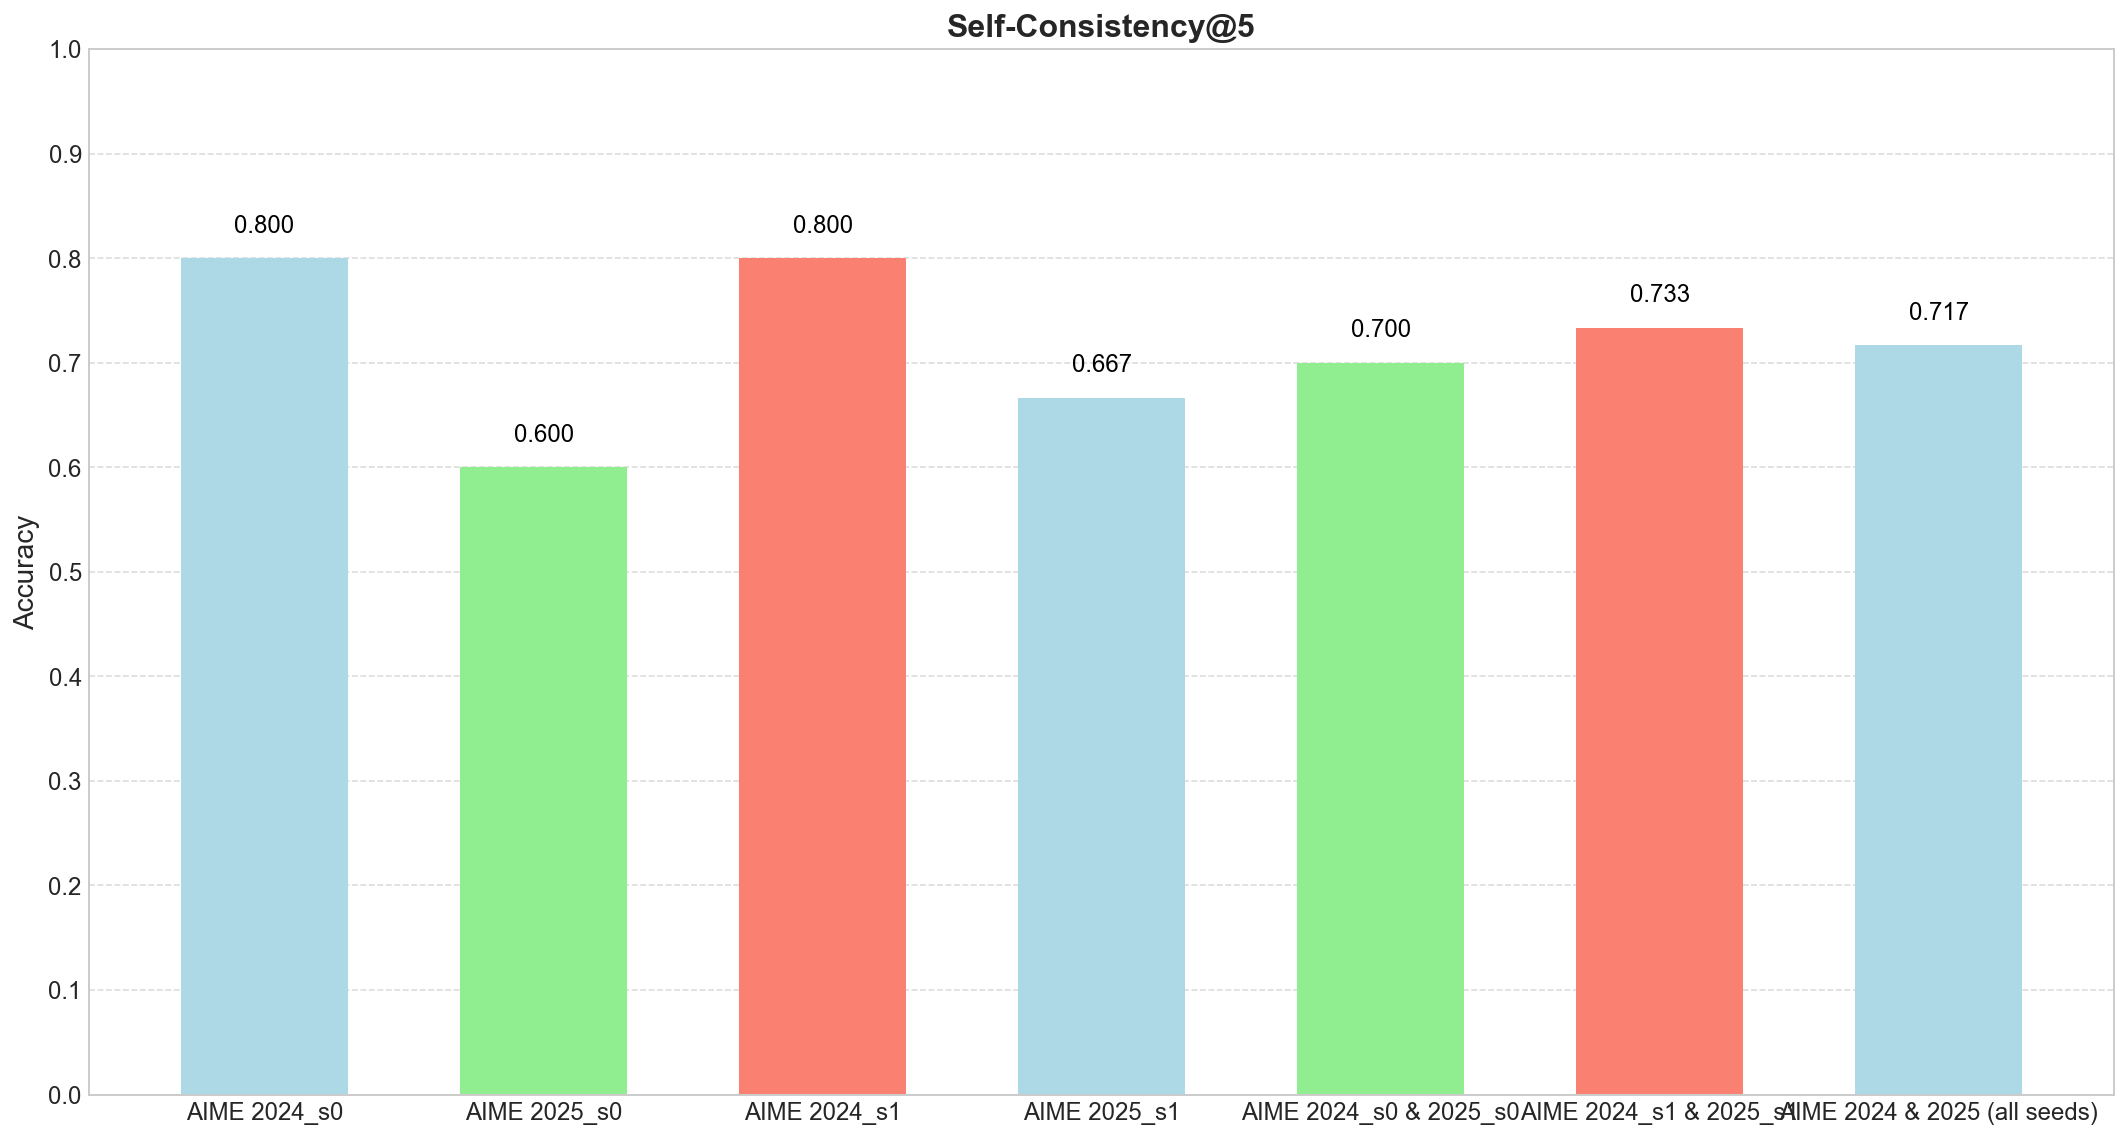

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np # For np.nan handling if necessary

# --- Assume df_results is already populated as per the previous step ---
# For demonstration, I'll recreate a sample df_results.
# In your actual code, df_results would already exist.

# --- End of sample data recreation ---

# Ensure the 'self_consistent_0_1' column is numeric

# Calculate accuracies
# Drop rows where self_consistent_0_1 might be NaN after coercion, if any

accuracy_2024_s0 = self_consistency_results[self_consistency_results['year'] == '2024_s0']['self_consistent'].mean()
accuracy_2025_s0 = self_consistency_results[self_consistency_results['year'] == '2025_s0']['self_consistent'].mean()
accuracy_2024_s1 = self_consistency_results[self_consistency_results['year'] == '2024_s1']['self_consistent'].mean()
accuracy_2025_s1 = self_consistency_results[self_consistency_results['year'] == '2025_s1']['self_consistent'].mean()

accuracy_combined_s0 = self_consistency_results[(self_consistency_results['year'] == '2024_s0') | (self_consistency_results['year'] == '2025_s0')]['self_consistent'].mean()
accuracy_combined_s1 = self_consistency_results[(self_consistency_results['year'] == '2024_s1') | (self_consistency_results['year'] == '2025_s1')]['self_consistent'].mean()

accuracy_combined = self_consistency_results['self_consistent'].mean()
# Handle cases where a year might have no data, resulting in NaN accuracy
accuracies = {
    'AIME 2024_s0': accuracy_2024_s0 if not np.isnan(accuracy_2024_s0) else 0,
    'AIME 2025_s0': accuracy_2025_s0 if not np.isnan(accuracy_2025_s0) else 0,
    'AIME 2024_s1': accuracy_2024_s1 if not np.isnan(accuracy_2024_s1) else 0,
    'AIME 2025_s1': accuracy_2025_s1 if not np.isnan(accuracy_2025_s1) else 0,
    'AIME 2024_s0 & 2025_s0': accuracy_combined_s0 if not np.isnan(accuracy_combined_s0) else 0,
    'AIME 2024_s1 & 2025_s1': accuracy_combined_s1 if not np.isnan(accuracy_combined_s1) else 0,
    'AIME 2024 & 2025 (all seeds)': accuracy_combined if not np.isnan(accuracy_combined) else 0
}

labels = list(accuracies.keys())
values = list(accuracies.values())

# Create the plot
plt.style.use('seaborn-v0_8-whitegrid') # Using a seaborn style for better aesthetics
fig, ax = plt.subplots(figsize=(15, 8))

bars = ax.bar(labels, values, color=['lightblue', 'lightgreen', 'salmon'], width=0.6)

# Add labels and title
ax.set_ylabel('Accuracy', fontsize=14)
# ax.set_xlabel('Dataset', fontsize=14)
ax.set_title('Self-Consistency@5', fontsize=16, fontweight='bold')
ax.set_ylim(0, 1) # Set y-axis limit up to 1.1 for better visualization of values near 1.0

# Add value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02, f'{yval:.3f}', # Format to 3 decimal places
             ha='center', va='bottom', fontsize=12, color='black')

# Customize ticks
plt.xticks(fontsize=12)
plt.yticks(np.arange(0, 1.1, 0.1), fontsize=12) # Y-ticks from 0 to 1 with step 0.1
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.grid(axis='x', linestyle='') # Remove vertical grid lines

# Add a light background color for the plot area
ax.set_facecolor('white')
fig.patch.set_facecolor('white') # Set figure background to white

plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

# # Print the accuracies as well
# print("Self-Consistency@5 Accuracies:")
# print(f"  2024: {accuracies['AIME 2024']:.3f}")
# print(f"  2025: {accuracies['AIME 2025']:.3f}")
# print(f"  Combined: {accuracies['AIME 2024 & 2025']:.3f}")


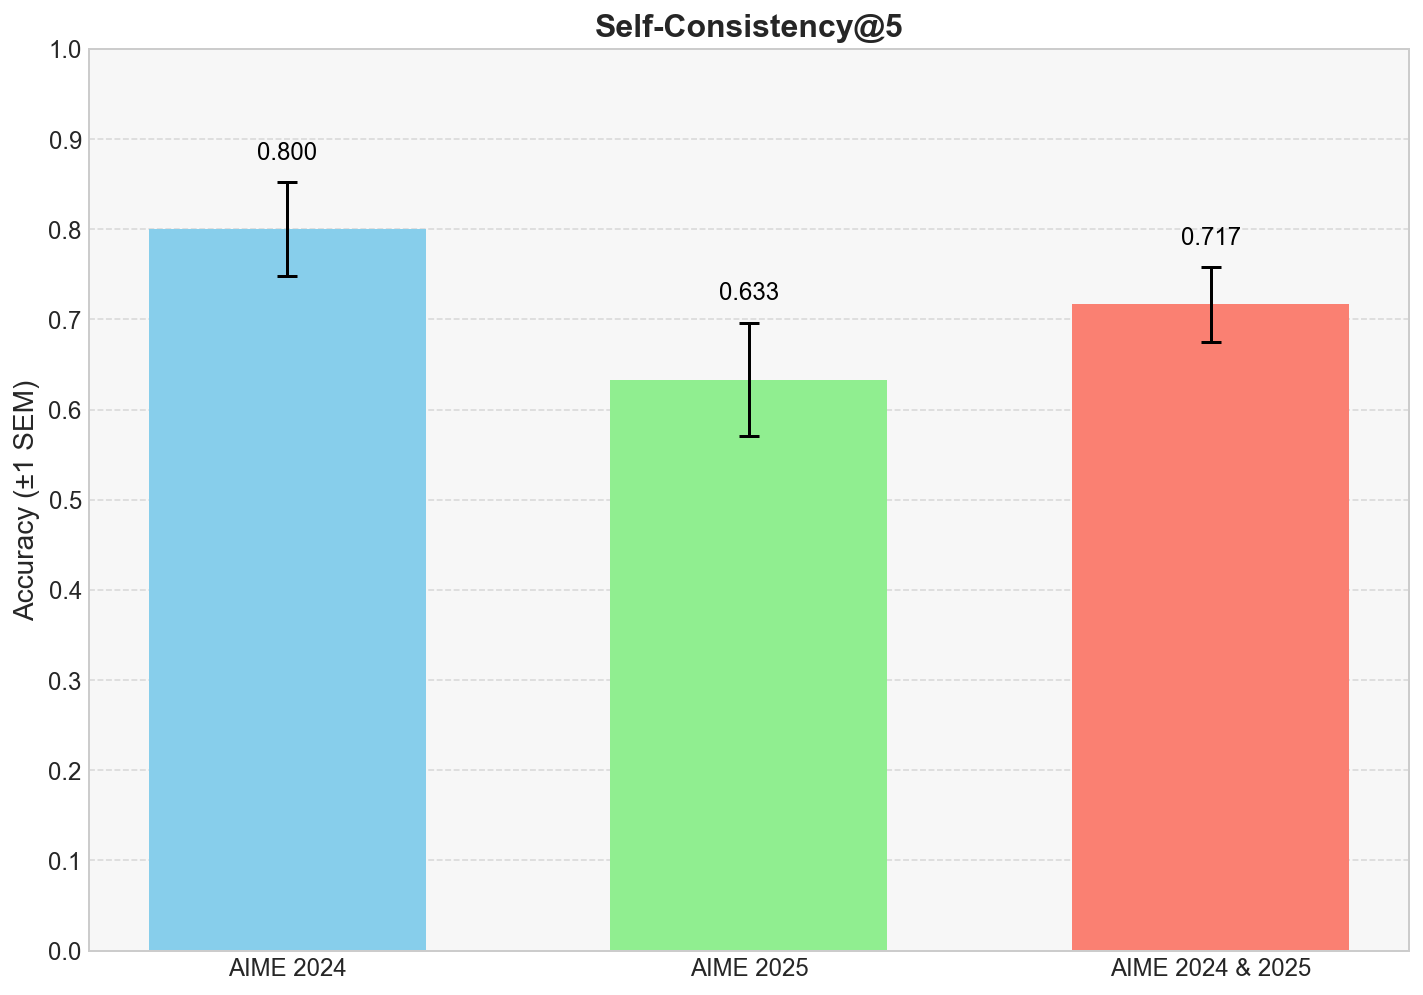

Mean Self-Consistency@5 Accuracies (mu ± SEM):
  AIME 2024 (avg. seeds): 0.800 ± 0.052
  AIME 2025 (avg. seeds): 0.633 ± 0.063
  AIME Combined (avg. seeds): 0.717 ± 0.041


In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import sem # For calculating Standard Error of the Mean

# --- Assume self_consistency_results DataFrame is already populated ---
# For demonstration, I'll recreate a sample self_consistency_results DataFrame.
# In your actual code, this DataFrame would already exist from your previous steps.

# --- End of sample data recreation ---

# Ensure the 'self_consistent' column is numeric
self_consistency_results['self_consistent'] = pd.to_numeric(self_consistency_results['self_consistent'], errors='coerce')
self_consistency_results.dropna(subset=['self_consistent'], inplace=True)

# --- Calculate Mean Accuracies and SEMs ---

# Function to calculate mean and SEM for a given series
def get_mean_and_sem(series):
    if series.empty or len(series) < 2: # SEM is not well-defined for N<2
        return series.mean() if not series.empty else 0, 0 
    mean_val = series.mean()
    sem_val = sem(series) # from scipy.stats.sem
    # Alternatively, using pandas: sem_val = series.sem()
    # Or manually: sem_val = series.std() / np.sqrt(series.count())
    return mean_val, sem_val

# 2024 seeds
df_2024_seeds = self_consistency_results[self_consistency_results['year'].str.startswith('2024')]
mean_2024, sem_2024 = get_mean_and_sem(df_2024_seeds['self_consistent'])

# 2025 seeds
df_2025_seeds = self_consistency_results[self_consistency_results['year'].str.startswith('2025')]
mean_2025, sem_2025 = get_mean_and_sem(df_2025_seeds['self_consistent'])

# Combined (all 2024 and 2025 seeds)
df_combined_seeds = self_consistency_results[
    self_consistency_results['year'].str.startswith('2024') | 
    self_consistency_results['year'].str.startswith('2025')
]
mean_combined, sem_combined = get_mean_and_sem(df_combined_seeds['self_consistent'])

# Prepare data for plotting
labels = ['AIME 2024', 'AIME 2025', 'AIME 2024 & 2025']
means = [mean_2024, mean_2025, mean_combined]
sems = [sem_2024, sem_2025, sem_combined]

# --- Create the plot ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 7)) # Adjusted figsize for better label fit

bar_colors = ['skyblue', 'lightgreen', 'salmon'] # Colors for 2024, 2025, Combined

bars = ax.bar(labels, means, yerr=sems, capsize=5, color=bar_colors, width=0.6, 
              ecolor='black', error_kw={'elinewidth':1.5, 'capthick':1.5})

# Add labels and title
ax.set_ylabel('Accuracy (±1 SEM)', fontsize=14)
# ax.set_xlabel('Dataset Group', fontsize=14) # X-axis labels are descriptive enough
ax.set_title('Self-Consistency@5', fontsize=16, fontweight='bold')
ax.set_ylim(0, 1) # Adjust y-axis limit if accuracies are expected to be lower

# Add value labels on top of each bar (for the mean)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02 + (sems[bars.patches.index(bar)] if yval + sems[bars.patches.index(bar)] < 1 else 0.01) , # Adjust label position based on error bar
             f'{yval:.3f}', ha='center', va='bottom', fontsize=12, color='black', fontweight='medium')

# Customize ticks
plt.xticks(fontsize=12, rotation=0) # Rotate x-labels if they overlap
plt.yticks(np.arange(0, 1.1, 0.1), fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.grid(axis='x', linestyle='') # Remove vertical grid lines

# Add a light background color for the plot area
ax.set_facecolor('#f7f7f7')
fig.patch.set_facecolor('white')

plt.tight_layout()
plt.show()

# Print the means and SEMs
print("Mean Self-Consistency@5 Accuracies (mu ± SEM):")
print(f"  AIME 2024 (avg. seeds): {mean_2024:.3f} ± {sem_2024:.3f}")
print(f"  AIME 2025 (avg. seeds): {mean_2025:.3f} ± {sem_2025:.3f}")
print(f"  AIME Combined (avg. seeds): {mean_combined:.3f} ± {sem_combined:.3f}")


In [74]:
import json
import os
from collections import Counter

def extract_problem_ids(data):
    """
    Extracts all problem_id values from the given JSON-like data structure.
    Assumes 'data' has a 'results' key containing a list of dicts,
    and each dict in that list has a 'problem_id' key.

    Args:
        data (dict): A dictionary representing the JSON data.

    Returns:
        list: A list of all problem_id values found. Returns an empty list
              if 'results' key is missing, not a list, or items lack 'problem_id'.
    """
    problem_ids = []
    if "results" in data and isinstance(data["results"], list):
        for item in data["results"]:
            if isinstance(item, dict) and "problem_id" in item:
                problem_ids.append(item["problem_id"])
            # else:
                # print(f"Warning: Item found in 'results' list without a 'problem_id' or not a dict: {item}")
    # else:
        # print("Warning: 'results' key not found in data or is not a list.")
    return problem_ids

def analyze_problem_ids_in_misc_files(base_directory="."):
    """
    Loads miscX.json files, extracts problem_ids, and counts their occurrences.

    Args:
        base_directory (str): The directory where miscX.json files are located.
    """
    all_problem_ids_from_files = []
    misc_filenames = [f"misc{i}.json" for i in range(1, 6)] # misc1.json to misc5.json

    print(f"Looking for files in directory: {os.path.abspath(base_directory)}")

    for filename in misc_filenames:
        file_path = os.path.join(base_directory, filename)
        print(f"\nProcessing file: {file_path}")
        if os.path.exists(file_path):
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                
                ids_in_file = extract_problem_ids(data)
                if ids_in_file:
                    print(f"  Found {len(ids_in_file)} problem_ids: {Counter(ids_in_file)}")
                    all_problem_ids_from_files.extend(ids_in_file)
                else:
                    print(f"  No problem_ids found or 'results' structure was not as expected in {filename}.")
                    
            except json.JSONDecodeError:
                print(f"  Error: Could not decode JSON from {filename}.")
            except Exception as e:
                print(f"  An unexpected error occurred while processing {filename}: {e}")
        else:
            print(f"  Error: File not found: {filename}")

    if not all_problem_ids_from_files:
        print("\nNo problem IDs were extracted from any file.")
        return

    print("\n--- Overall Problem ID Counts Across All Misc Files ---")
    problem_id_counts = Counter(all_problem_ids_from_files)
    
    if not problem_id_counts:
        print("No problem IDs were found in total.")
    else:
        for pid, count in problem_id_counts.items():
            print(f"  Problem ID '{pid}': {count} occurrences")
        print(f"\nTotal unique problem IDs found: {len(problem_id_counts)}")
        print(f"Total problem ID entries processed: {len(all_problem_ids_from_files)}")


TARGET_MISC_FILES_DIRECTORY = "/Users/justinshen/Documents/Code/cocolab/reasoning-distillation/paper_results/pass_consensus" 
    
    # Create dummy miscX.json files for demonstration if they don't exist
    # In a real scenario, you would have your actual files.
analyze_problem_ids_in_misc_files(base_directory=TARGET_MISC_FILES_DIRECTORY)


Looking for files in directory: /Users/justinshen/Documents/Code/cocolab/reasoning-distillation/paper_results/pass_consensus

Processing file: /Users/justinshen/Documents/Code/cocolab/reasoning-distillation/paper_results/pass_consensus/misc1.json
  Found 45 problem_ids: Counter({'2024-I-4': 1, '2024-II-4': 1, '2024-I-3': 1, '2024-II-12': 1, '2024-I-11': 1, '2024-I-8': 1, '2024-II-11': 1, '2024-I-12': 1, '2024-I-2': 1, '2024-II-6': 1, '2024-I-7': 1, '2024-I-1': 1, '2024-I-6': 1, '2024-II-3': 1, '2024-I-13': 1, '2024-II-10': 1, '2024-II-7': 1, '2024-I-15': 1, '2024-II-15': 1, '2024-II-9': 1, '2024-II-1': 1, '2024-II-14': 1, '2024-II-5': 1, '2024-II-2': 1, '2024-I-9': 1, '2024-I-10': 1, '2024-II-8': 1, '1': 1, '0': 1, '2024-I-14': 1, '2024-I-5': 1, '2024-II-13': 1, '3': 1, '2': 1, '4': 1, '8': 1, '5': 1, '6': 1, '7': 1, '9': 1, '10': 1, '15': 1, '16': 1, '11': 1, '18': 1})

Processing file: /Users/justinshen/Documents/Code/cocolab/reasoning-distillation/paper_results/pass_consensus/misc2.

In [75]:
import json
import os
from collections import Counter

def aggregate_unique_problems(base_directory=".", output_filename="aggregated_unique_problems.json"):
    """
    Loads miscX.json files, identifies unique problem_ids, and aggregates the first
    encountered instance of each unique problem into a new JSON file.
    Also reports which instances were kept and which were skipped.

    Args:
        base_directory (str): The directory where miscX.json files are located.
        output_filename (str): Name for the output JSON file.
    """
    
    processed_problem_ids = set() # To keep track of problem_ids already added
    aggregated_results_list = []  # To store the problem data for the output JSON
    
    # To log kept and skipped items
    kept_items_log = []
    skipped_items_log = []

    misc_filenames = [f"misc{i}.json" for i in range(1, 6)] # misc1.json to misc5.json

    print(f"Looking for files in directory: {os.path.abspath(base_directory)}")

    for filename in misc_filenames:
        file_path = os.path.join(base_directory, filename)
        print(f"\nProcessing file: {file_path}")
        
        if os.path.exists(file_path):
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                
                if "results" in data and isinstance(data["results"], list):
                    problems_in_file = data["results"]
                    if not problems_in_file:
                        print(f"  No problems found in 'results' list in {filename}.")
                        continue
                        
                    for problem_index, problem_data_item in enumerate(problems_in_file):
                        if isinstance(problem_data_item, dict):
                            current_problem_id = problem_data_item.get("problem_id")
                            
                            if current_problem_id is None:
                                skipped_items_log.append({
                                    "reason": "Missing problem_id",
                                    "source_file": filename,
                                    "problem_index_in_file": problem_index,
                                    "problem_data_snippet": str(problem_data_item)[:100] # Snippet for identification
                                })
                                continue

                            if current_problem_id not in processed_problem_ids:
                                # This is the first time we're seeing this problem_id
                                aggregated_results_list.append(problem_data_item)
                                processed_problem_ids.add(current_problem_id)
                                kept_items_log.append({
                                    "problem_id": current_problem_id,
                                    "source_file": filename,
                                    "problem_index_in_file": problem_index
                                    # "question": problem_data_item.get("question", "")[:50] # Optional: add more details
                                })
                            else:
                                # This problem_id is a duplicate
                                skipped_items_log.append({
                                    "reason": "Duplicate problem_id",
                                    "problem_id": current_problem_id,
                                    "source_file": filename,
                                    "problem_index_in_file": problem_index
                                    # "question": problem_data_item.get("question", "")[:50]
                                })
                        else:
                            skipped_items_log.append({
                                "reason": "Item in 'results' not a dictionary",
                                "source_file": filename,
                                "problem_index_in_file": problem_index,
                                "item_data_snippet": str(problem_data_item)[:100]
                            })
                else:
                    print(f"  'results' key not found or is not a list in {filename}. File might have unexpected structure.")
                    
            except json.JSONDecodeError:
                print(f"  Error: Could not decode JSON from {filename}.")
                skipped_items_log.append({"reason": "JSONDecodeError", "source_file": filename})
            except Exception as e:
                print(f"  An unexpected error occurred while processing {filename}: {e}")
                skipped_items_log.append({"reason": str(e), "source_file": filename})
        else:
            print(f"  Error: File not found: {filename}")
            skipped_items_log.append({"reason": "File not found", "source_file": filename})

    # --- Output the aggregated JSON ---
    # The structure of the output JSON will be similar to the input,
    # with a "results" key containing the list of unique problems.
    # You might want to include other top-level keys from one of the misc files
    # (e.g., "config", "reasoning_prompt_template") if they are consistent and needed.
    # For simplicity, this example just outputs the "results".
    
    output_data_structure = {
        # You could try to copy "config" and "reasoning_prompt_template" from the first misc file
        # if they exist and are relevant for the aggregated set.
        # For example:
        # "config": data_from_first_successful_file.get("config", {}), 
        # "reasoning_prompt_template": data_from_first_successful_file.get("reasoning_prompt_template", ""),
        "results": aggregated_results_list
    }
    
    output_file_path = os.path.join(base_directory, output_filename)
    try:
        with open(output_file_path, 'w', encoding='utf-8') as f:
            json.dump(output_data_structure, f, indent=2) # indent for readability
        print(f"\nSuccessfully aggregated {len(aggregated_results_list)} unique problems into: {output_file_path}")
    except Exception as e:
        print(f"\nError writing output JSON file {output_file_path}: {e}")

    # --- Report on kept and skipped items ---
    print("\n--- Aggregation Report ---")
    print(f"\nTotal unique problem_ids kept: {len(kept_items_log)}")
    print("Details of kept items (problem_id: source_file[index_in_file]):")
    for item in kept_items_log:
        print(f"  - Kept '{item['problem_id']}': from {item['source_file']} (index {item['problem_index_in_file']})")

    print(f"\nTotal problem instances skipped: {len(skipped_items_log)}")
    if skipped_items_log:
        print("Details of skipped items:")
        for item in skipped_items_log:
            if item['reason'] == "Duplicate problem_id":
                 print(f"  - Skipped Duplicate '{item['problem_id']}': from {item['source_file']} (index {item['problem_index_in_file']})")
            elif item['reason'] == "Missing problem_id":
                 print(f"  - Skipped Missing problem_id: from {item['source_file']} (index {item['problem_index_in_file']}), data: {item.get('problem_data_snippet', 'N/A')}")
            else:
                 print(f"  - Skipped due to '{item['reason']}': in {item['source_file']}, details: {item.get('item_data_snippet') or item.get('problem_id', 'N/A')}")
                 
    # Optionally save report to a text file
    report_filename = os.path.join(base_directory, "aggregation_report.txt")
    try:
        with open(report_filename, 'w', encoding='utf-8') as rf:
            rf.write("--- Aggregation Report ---\n\n")
            rf.write(f"Total unique problem_ids kept: {len(kept_items_log)}\n")
            rf.write("Details of kept items (problem_id: source_file[index_in_file]):\n")
            for item in kept_items_log:
                rf.write(f"  - Kept '{item['problem_id']}': from {item['source_file']} (index {item['problem_index_in_file']})\n")
            
            rf.write(f"\nTotal problem instances skipped: {len(skipped_items_log)}\n")
            if skipped_items_log:
                rf.write("Details of skipped items:\n")
                for item in skipped_items_log:
                    if item['reason'] == "Duplicate problem_id":
                         rf.write(f"  - Skipped Duplicate '{item['problem_id']}': from {item['source_file']} (index {item['problem_index_in_file']})\n")
                    elif item['reason'] == "Missing problem_id":
                         rf.write(f"  - Skipped Missing problem_id: from {item['source_file']} (index {item['problem_index_in_file']}), data: {item.get('problem_data_snippet', 'N/A')}\n")
                    else:
                         rf.write(f"  - Skipped due to '{item['reason']}': in {item['source_file']}, details: {item.get('item_data_snippet') or item.get('problem_id', 'N/A')}\n")
            print(f"\nAggregation report saved to: {report_filename}")
    except Exception as e:
        print(f"\nError writing aggregation report file {report_filename}: {e}")


# --- Example of how to run this ---
# Set this to the directory where your misc1.json, misc2.json, etc. files are located.
# Based on your output, this should be:
TARGET_MISC_FILES_DIRECTORY = "/Users/justinshen/Documents/Code/cocolab/reasoning-distillation/paper_results/pass_consensus" 

# Create dummy miscX.json files for demonstration ONLY IF THE REAL FILES ARE NOT PRESENT
# and if the target directory is the current directory (for safety in this example).
# In your case, you have real files, so this part is likely not needed or should be used cautiously.
if TARGET_MISC_FILES_DIRECTORY == ".": # Only run dummy creation if target is current dir
    print("--- Setting up dummy files for demonstration (if target is '.') ---")
    # (Dummy file creation logic would go here, similar to the previous example if needed)
    # For your case, since you have real files, this part can be skipped.
    pass
else:
    print(f"--- Running with specified directory: {TARGET_MISC_FILES_DIRECTORY} ---")


aggregate_unique_problems(base_directory=TARGET_MISC_FILES_DIRECTORY, 
                            output_filename="aggregated_60_unique_problems.json")

--- Running with specified directory: /Users/justinshen/Documents/Code/cocolab/reasoning-distillation/paper_results/pass_consensus ---
Looking for files in directory: /Users/justinshen/Documents/Code/cocolab/reasoning-distillation/paper_results/pass_consensus

Processing file: /Users/justinshen/Documents/Code/cocolab/reasoning-distillation/paper_results/pass_consensus/misc1.json

Processing file: /Users/justinshen/Documents/Code/cocolab/reasoning-distillation/paper_results/pass_consensus/misc2.json

Processing file: /Users/justinshen/Documents/Code/cocolab/reasoning-distillation/paper_results/pass_consensus/misc3.json

Processing file: /Users/justinshen/Documents/Code/cocolab/reasoning-distillation/paper_results/pass_consensus/misc4.json

Processing file: /Users/justinshen/Documents/Code/cocolab/reasoning-distillation/paper_results/pass_consensus/misc5.json

Successfully aggregated 60 unique problems into: /Users/justinshen/Documents/Code/cocolab/reasoning-distillation/paper_results/pa